## Trying to plot the mode intensity of the material
---

### The QCL material and structure
- The code represents the same material structure of the figure.  
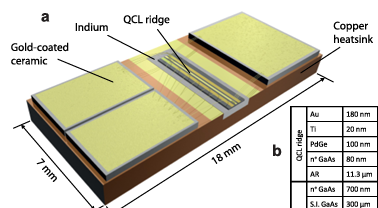
- The height is in the y axis, the length is in the x axis.  
- Grating structure is also recorded in this part of the code.  

In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from meep.materials import Au

###---------------------------------------------------------------basic config-------------------------------------------------------------------###
sx = 60
sy = 6
dpml = 1  # PML thickness
cell = mp.Vector3(sx, sy, 0)
sy = sy - dpml*2
fcen = 1e12
resolution = 50

# thickness of different layers（1 μm）
au_thickness = 0.18
ngaas_thickness_1 = 0.08
Active_region_thickness = 0.0113
ngaas_thickness_2 = 0.7
sigaas_thickness = 5
w = au_thickness + ngaas_thickness_1 + Active_region_thickness + ngaas_thickness_2 + sigaas_thickness # width of waveguide

###---------------------------------------------------------------material config-------------------------------------------------------------------###
# material definition
Active_region = mp.air
# Au = mp.Medium(epsilon=1.0, D_conductivity=1e7)
GaAs_low_doped = mp.Medium(epsilon=12.9, D_conductivity=0)
GaAs_high_doped = mp.Medium(epsilon=5, D_conductivity=100)

n_GaAs = mp.Medium(
    epsilon=10.9,  # 高频极限介电常数
    E_susceptibilities=[
        mp.DrudeSusceptibility(
            frequency=0.37,
            gamma=0.01,
            sigma=1.0
        )])

###-------------------------------------------------------------geometry---------------------------------------------------------------------###
geometry = []
# Substrate
geometry.append(mp.Block(
                    material=GaAs_low_doped,
                    size=mp.Vector3(mp.inf,sigaas_thickness,mp.inf),
                    center=mp.Vector3(y = -sy/2 + sigaas_thickness/2)))

geometry.append(mp.Block(
                    material=GaAs_high_doped,
                    size=mp.Vector3(mp.inf,ngaas_thickness_2,mp.inf),
                    center=mp.Vector3(y= -sy/2 + sigaas_thickness + ngaas_thickness_2/2)))

# QCL active region
geometry.append(mp.Block(
                    material=n_GaAs,
                    size=mp.Vector3(mp.inf,Active_region_thickness,mp.inf),
                    center=mp.Vector3(y= -sy/2 + sigaas_thickness + ngaas_thickness_2 + Active_region_thickness/2)))

# upper layers
y0 = -sy/2 + sigaas_thickness + ngaas_thickness_2 + Active_region_thickness
geometry += [
    mp.Block(material = GaAs_high_doped, 
            size = mp.Vector3(mp.inf,ngaas_thickness_1,mp.inf), 
            center = mp.Vector3(y = y0 + ngaas_thickness_1/2)),
    mp.Block(material = Au,    
            size = mp.Vector3(mp.inf,au_thickness,mp.inf),    
            center = mp.Vector3(y = y0 + ngaas_thickness_1 + au_thickness/2))]

###-------------------------------------------------------------grating parameters---------------------------------------------------------------------###
pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern = pattern_1 + pattern_2

r = 0.15  # radius of holes
d = 1  # defect spacing (ordinary spacing = 1)
N = 0  # number of holes on either side of defect

if N == 0:
    pass
else:
    for i, symbol in enumerate(pattern):
        if symbol == "|":
            x_pos = -sx/2 + i * d
            geometry.append(mp.Cylinder(r, center=mp.Vector3(x=x_pos,y=y0 + ngaas_thickness_1 + au_thickness/2)))
        else:
            x_pos = -sx/2 + i * d * 0.5

pml_layers = [mp.PML(1.0)]
# fcen = 0.25  # pulse center frequency
df = 0.2  # pulse frequency width

src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(-0.5 * sx + dpml),
        size=mp.Vector3(0, sy))]

# sym = [mp.Mirror(mp.Y, phase=-1)]
###-------------------------------------------------------------simulation setup---------------------------------------------------------------------###
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    # symmetries=sym,
        resolution=resolution)

### Trying to reappear mode intensity with another 2 structure
---
- Plasmon waveguide  
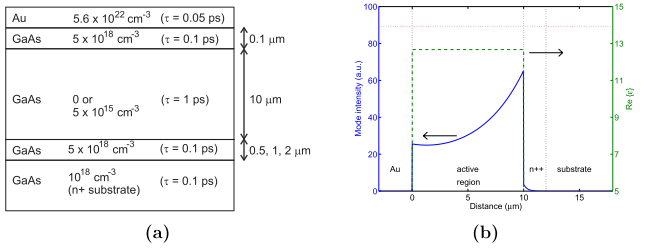
  
- Metal-metal waveguide  
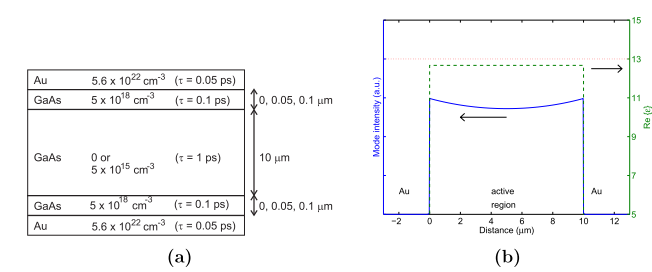

- The height is in the x axis and length is in the z axis.  

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au

# basic setup (1 μm)
resolution = 50
sx = 13
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)
# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 1
n_GaAs_thickness = 0.1
light_GaAs_thickness = 10

###---------------------------------------------------------------basic config-------------------------------------------------------------------###
# Au = mp.Medium(
#     epsilon=1.0,
#     E_susceptibilities=[
#         mp.DrudeSusceptibility(
#             frequency=5.0,
#             gamma=0.5,    
#             sigma=1.0)])

# N = 5e18
# n_GaAs = mp.Medium(epsilon=12.25)
n_GaAs = mp.Medium(
    epsilon=10.9,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=1.62, 
                               gamma=0.033, 
                               sigma=1.0)])


# N = 5e15 低参杂
# light_GaAs = mp.Medium(epsilon=12.25)
light_GaAs = mp.Medium(
    epsilon=12.25,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.0513, 
                               gamma=0.0033, 
                               sigma=1.0)])

# 1e18
nplus_GaAs = mp.Medium(
    epsilon=10.9,  
    E_susceptibilities=[
        mp.DrudeSusceptibility(
            frequency=0.7252,   # Plasma resonant frequency
            gamma=0.0333,       # damping constant
            sigma=1.0           # conductivity
        )
    ]
)

# Set up for source frequency 
frequency = 5e12 # 5THz
# Set up for detector 's observe range
observe_range = 0.1

###-------------------------------------------------------------geometry---------------------------------------------------------------------###
# define the basic height of layers
x0 = -0.5 * (Au_thickness + n_GaAs_thickness + light_GaAs_thickness + n_GaAs_thickness + Au_thickness)

# Construct layers
geometry = []
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),center=mp.Vector3(center_x, 0, 0),material=material))
    x0 += thickness

# this config can switch the structure between Plasmon and Metal-Metal
# add_layer(Au_thickness, nplus_GaAs)
# add_layer(2, n_GaAs)
add_layer(Au_thickness, Au)
add_layer(n_GaAs_thickness, n_GaAs)
add_layer(light_GaAs_thickness,light_GaAs)
add_layer(n_GaAs_thickness, n_GaAs)
add_layer(Au_thickness, Au)

###-----------------------------------------------------------source------------------------------------------------------------------------###
# Source
sources = [mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ex,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0)),
                    mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ey,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0)),
                    mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ez,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0))]

# Simulation setup
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    dimensions=2)

# sim.plot2D()

sim.run(until=10)
# 采样 y 方向 Ez 场强
x = np.linspace(-sx/2, sx/2, 1000)
eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0)) for xi in x])
ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2/2) for xi in x])
ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2/2) for xi in x])
ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2/2) for xi in x])

# === 画图 Ex === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ex|', color=color)
ax1.plot(x, ex_data, color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ex_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()

# === 画图 Ey === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ey|', color=color)
ax1.plot(x, ey_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ey_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()

# === 画图 Ez === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ez|', color=color)
ax1.plot(x, ez_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ez_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()


#### loop the time to see the result


-----------
Initializing structure...
time for choose_chunkdivision = 1.5974e-05 s
Working in 2D dimensions.
Computational cell is 13 x 0.02 x 0 with resolution 50
     block, center = (0,0,0)
          size (1e+20,0,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
time for set_epsilon = 0.00236988 s
-----------
run 0 finished at t = 10.0 (1000 timesteps)


/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


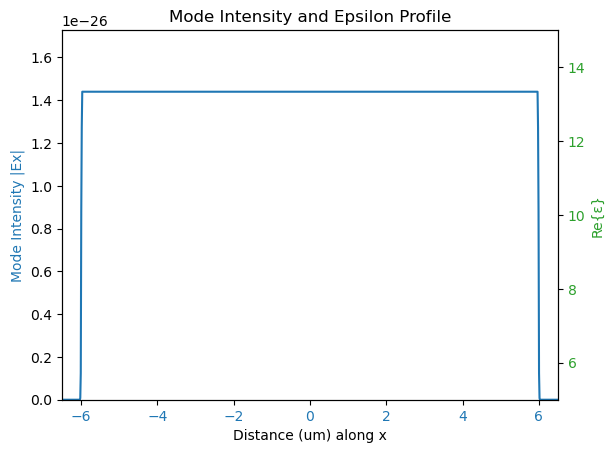

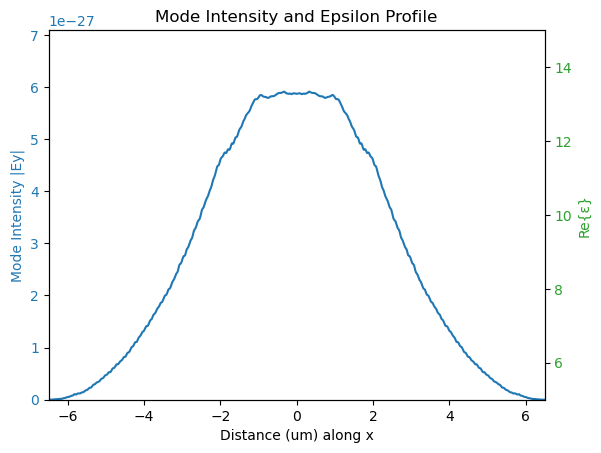

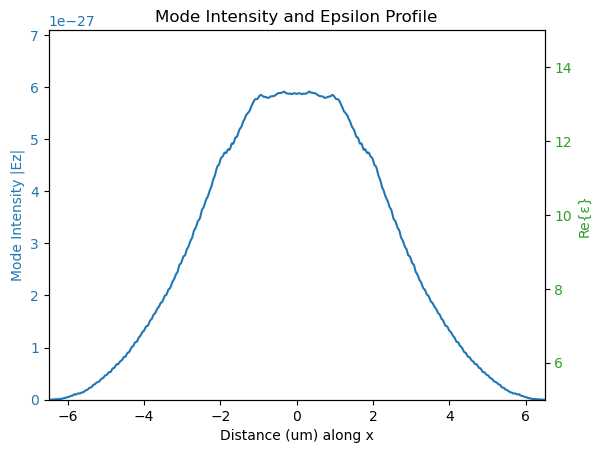

In [ ]:
for i in range (10,100,10):
    sim.run(until=i)
    ###-------------------------------------------------------------Plot--------------------------------------------------------------------###

    # 采样 x 方向 Ex 场强
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0)) for xi in x])
    ex_data = np.array([sim.get_field_point(mp.Ex, mp.Vector3(xi))**2/2 for xi in x])

    # === 画图 === #
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(-sx/2+1,sx/2-1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 13)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()

### Try the default materials (epislon = 13) and plot the mode intensity from 3 directions
---

     block, center = (0,0,0)
          size (1e+20,0,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11,11,11)
-----------
Initializing structure...
time for choose_chunkdivision = 8.82149e-06 s
Working in 2D dimensions.
Computational cell is 13 x 0.02 x 0 with resolution 50
     block, center = (0,0,0)
          size (1e+20,0,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11,11,11)
time for set_epsilon = 0.00240993 s
-----------
run 0 finished at t = 10.0 (1000 timesteps)


/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


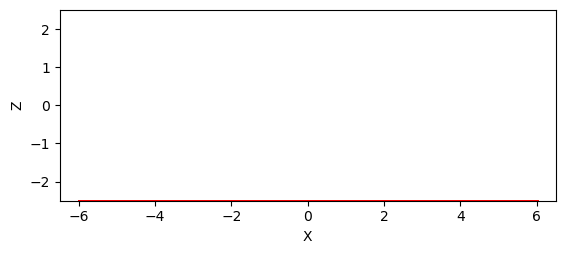

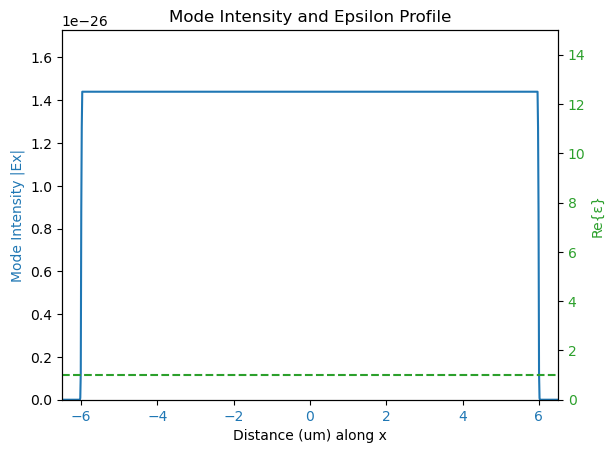

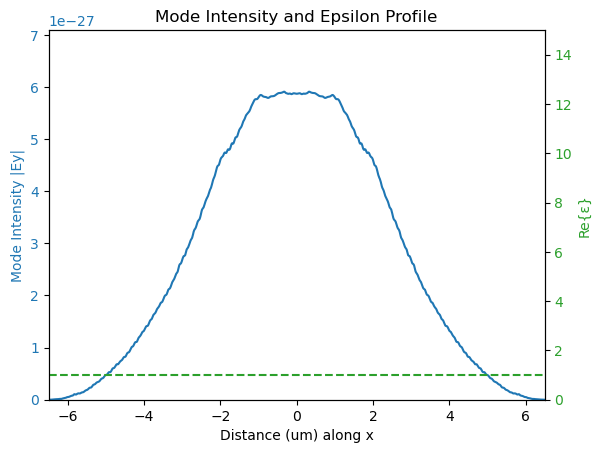

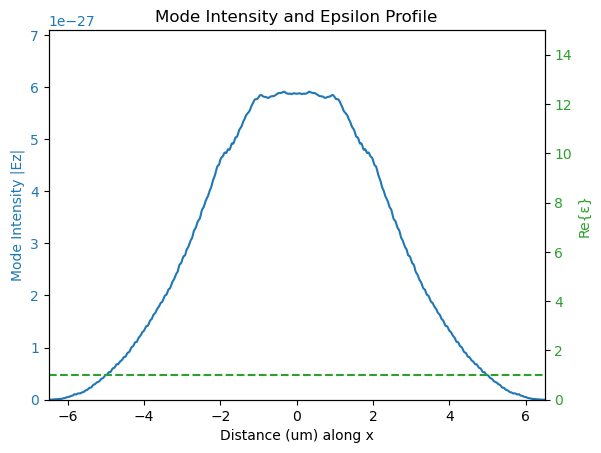

In [5]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au

# basic setup (1 μm)
resolution = 50
sx = 13
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)
# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）

# Set up for source frequency 
frequency = 5e12 # 5THz
# Set up for detector 's observe range
observe_range = 0.1

###-------------------------------------------------------------geometry---------------------------------------------------------------------###
blk = mp.Block(size=mp.Vector3(mp.inf, sy, mp.inf), material=mp.Medium(epsilon=11))
geometry = [blk]
###-----------------------------------------------------------source------------------------------------------------------------------------###
# Source
sources = [mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ex,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0)),
                    mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ey,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0)),
                    mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ez,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0))]

# Simulation setup
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    dimensions=2)
sim.plot2D()
sim.run(until=10)

# 采样 y 方向 Ez 场强
x = np.linspace(-sx/2, sx/2, 1000)
eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0)) for xi in x])
ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2/2) for xi in x])
ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2/2) for xi in x])
ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2/2) for xi in x])

# === 画图 Ex === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ex|', color=color)
ax1.plot(x, ex_data, color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ex_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()

# === 画图 Ey === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ey|', color=color)
ax1.plot(x, ey_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ey_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()

# === 画图 Ez === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ez|', color=color)
ax1.plot(x, ez_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ez_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()


### Try the material with just air and no grating structure
---

-----------
Initializing structure...
time for choose_chunkdivision = 1.3113e-05 s
Working in 2D dimensions.
Computational cell is 13 x 0.02 x 0 with resolution 50
     block, center = (0,0,0)
          size (1e+20,0,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.001724 s
-----------
run 0 finished at t = 10.0 (1000 timesteps)


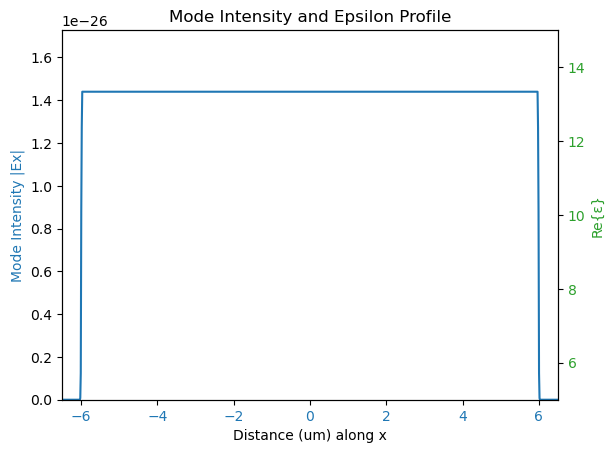

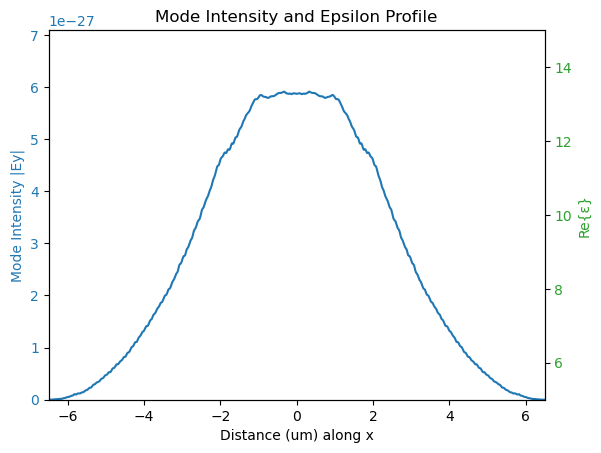

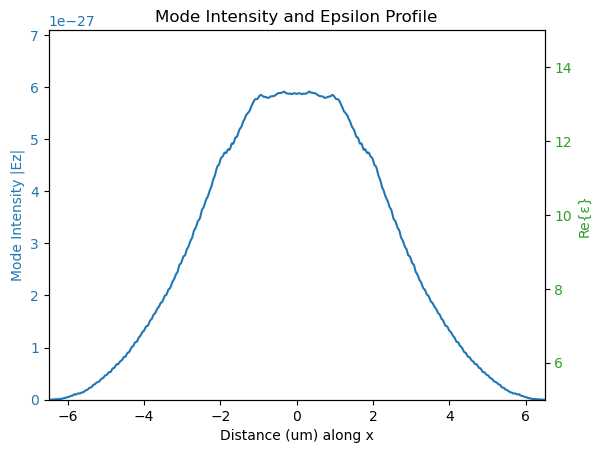

In [4]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au

# basic setup (1 μm)
resolution = 50
sx = 13
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)
# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）

# Set up for source frequency 
frequency = 5e12 # 5THz
# Set up for detector 's observe range
observe_range = 0.1

###-------------------------------------------------------------geometry---------------------------------------------------------------------###
blk = mp.Block(size=mp.Vector3(mp.inf, sy, mp.inf), material=mp.Medium(epsilon=1))
geometry = [blk]
###-----------------------------------------------------------source------------------------------------------------------------------------###
# Source
sources = [mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ex,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0)),
                    mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ey,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0)),
                    mp.Source(
            src=mp.ContinuousSource(frequency=frequency,fwidth=0.1*frequency,
                                    start_time=0,end_time=1e1),
                    component=mp.Ez,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(sx-1,0,0))]

# Simulation setup
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    dimensions=2)

sim.run(until=10)
# 采样 y 方向 Ez 场强
x = np.linspace(-sx/2, sx/2, 1000)
eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0)) for xi in x])
ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2/2) for xi in x])
ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2/2) for xi in x])
ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2/2) for xi in x])

# === 画图 Ex === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ex|', color=color)
ax1.plot(x, ex_data, color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ex_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()

# === 画图 Ey === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ey|', color=color)
ax1.plot(x, ey_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ey_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()

# === 画图 Ez === #
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Distance (um) along x')
ax1.set_ylabel('Mode Intensity |Ez|', color=color)
ax1.plot(x, ez_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(-sx/2,sx/2)
ax1.set_ylim(0, np.max(ez_data)*1.2)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Re{ε}', color=color)
ax2.plot(x, eps_data, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(5, 15)

plt.title('Mode Intensity and Epsilon Profile')
plt.show()
